<a href="https://colab.research.google.com/github/EnayatAria/UAV-image-classification-by-CNN/blob/main/CNN_vineyard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This part is for debugging the code
%xmode Verbose
%pdb on
from IPython.core.debugger import set_trace

Exception reporting mode: Verbose
Automatic pdb calling has been turned ON


In [ ]:
# reading the image data and ground truth
DataPath = '/content/drive/MyDrive/dataset/Gaillac-UAV-ML-2016-subset2/Gaillac-UAV-ML-2016-subset2'
txtPath='/content/drive/MyDrive/dataset/Gaillac-UAV-ML-2016-subset2/4_class_roi.txt'
savepath ='/content/drive/MyDrive/dataset/Gaillac-UAV-ML-2016-subset2/2DCNN-14_2.mat'
savemappath='/content/drive/MyDrive/dataset/Gaillac-UAV-ML-2016-subset2/ClassifiedMap.hdr'

In [ ]:
!pip install spectral

In [ ]:
 # Reading envi dataset
 import spectral.io.envi as envi
 img =envi.open(DataPath+'.hdr', DataPath)
 Data=img.load()
 #Data = Data.astype(np.float32)

In [ ]:
 # Reading the header of ENVI ROI  convereted to ASCII file by ENVI
 import pandas as pd
 f=open(txtPath,'r')
 line=f.readline()
 ROI_names=[]
 ROI_npts=[]
 while line != '':  # The EOF char is an empty string
    if 'Number of ROIs' in line:
      no_class=int(line[18])
    if 'File Dimension' in line:
      dim=line[18:]
      dim=dim.split(sep='x')
      x_dim=int(dim[0])
      y_dim=int(dim[1])
    if 'ROI name' in line:
      ROI_names.append(line[12:])
    if 'ROI npts' in line:
      ROI_npts.append(int(line[12:]))
    if line[0]!=';':
      break
    else:
      print(line, end='')
    line=f.readline()
f.close()

; ENVI Output of ROIs (5.6) [Fri Apr 23 14:00:12 2021]
; Number of ROIs: 4
; File Dimension: 2387 x 3622
;
; ROI name: Soil
; ROI rgb value: {255, 0, 0}
; ROI npts: 7442
;
; ROI name: Vine
; ROI rgb value: {0, 255, 0}
; ROI npts: 7065
;
; ROI name: Shadow
; ROI rgb value: {0, 0, 255}
; ROI npts: 5141
;
; ROI name: Grass
; ROI rgb value: {255, 255, 0}
; ROI npts: 5056
;    ID     X     Y      Map X       Map Y        Lat       Lon    B1    B2    B3    B4    B5


When filling the ROI_arr, the difference between the coordinate system of the image and an array should be considered.

In [ ]:
 # making ROI map
 import numpy as np
 f=open(txtPath,'r')
 line_no=0
 ROI_arr=np.zeros([y_dim, x_dim])
 cls_no=0
 for line in f:
   line_no+=1
   if line[0]!=';' and line[0]!='\n':
     #set_trace()
     if line[5:8]==' 1 ':
       cls_no+=1
     ROI_arr[int(line[15:19]),int(line[9:13])]=cls_no
f.close()


In [ ]:
# making training and test datasets
TrLabel = np.zeros([y_dim, x_dim])
TsLabel = np.zeros([y_dim, x_dim])
for i in range(no_class):
    jjj=0
    ind = np.where(ROI_arr == (i+1))
    indices=np.rint(np.linspace(0,ind[0].shape[0],3333, endpoint=False))
    indices=indices.astype(int)
    #set_trace()
    for jj in indices:
      TrLabel[ind[0][jj], ind[1][jj]]=i+1
      if jj != 0 and jj < ind[0].shape[0]:
        TsLabel[ind[0][jjj+1:jj], ind[1][jjj+1:jj]]=i+1
        jjj=jj
    print(np.nonzero(TsLabel)[0].shape)
    print(ind[0].shape)
  #  TsLabel[ind[0][:round(0.3*len(ind[0]))], ind[1][:round(0.3*len(ind[0]))]] = i+1
  #  TrLabel[ind[0][round(0.3 * len(ind[0])):], ind[1][round(0.3 * len(ind[0])):]] = i + 1

(4089,)
(7423,)
(7820,)
(7065,)
(9627,)
(5141,)
(11349,)
(5056,)


In [ ]:
print(np.nonzero(TrLabel)[1].shape)

(11353,)


In [ ]:
# some initialization
patchsize = 16  # input spatial size for 2D-CNN
batchsize = 128  # select from [16, 32, 64, 128], the best is 64
EPOCH = 200
LR = 0.001

In [ ]:
# without dimensionality reduction
pad_width = np.floor(patchsize / 2)
pad_width = np.int(pad_width)

# normalization method 2: map to zero mean and one std
[m, n, l] = np.shape(Data)
for i in range(l):
    mean = np.mean(Data[:, :, i])
    std = np.std(Data[:, :, i])
    Data[:, :, i] = (Data[:, :, i] - mean) / std

In [ ]:
x = Data
# boundary interpolation
temp = x[:, :, 0]
temp=np.squeeze(temp)
temp2 = np.pad(temp, pad_width, 'symmetric')
[m2, n2] = temp2.shape
x2 = np.empty((m2, n2, l), dtype='float32')
for i in range(l):
    temp = np.squeeze(x[:, :, i])
    pad_width = np.floor(patchsize / 2)
    pad_width = np.int(pad_width)
    temp2 = np.pad(temp, pad_width, 'symmetric')
    x2[:, :, i] = temp2

In [ ]:
# to check if cuda is available or not
# when the GPU is on from the 'Runtime' tab, the result would be 'True'
import torch
torch.cuda.is_available()

True

In [ ]:
import torch
import torch.utils.data as dataf

# construct the training and testing set
[ind1, ind2] = np.where(TrLabel != 0)
TrainNum = len(ind1)
TrainPatch = np.empty((TrainNum, l, patchsize, patchsize), dtype='float32')
TrainLabel = np.empty(TrainNum)
ind3 = ind1 + pad_width
ind4 = ind2 + pad_width
for i in range(len(ind1)):
    # patch = x2[(ind3[i] - pad_width):(ind3[i] + pad_width + 1), (ind4[i] - pad_width):(ind4[i] + pad_width + 1), :]
    patch = x2[(ind3[i] - pad_width):(ind3[i] + pad_width), (ind4[i] - pad_width):(ind4[i] + pad_width), :]
    patch = np.reshape(patch, (patchsize * patchsize, l))
    patch = np.transpose(patch)
    patch = np.reshape(patch, (l, patchsize, patchsize))
    TrainPatch[i, :, :, :] = patch
    patchlabel = TrLabel[ind1[i], ind2[i]]
    TrainLabel[i] = patchlabel

[ind1, ind2] = np.where(TsLabel != 0)
TestNum = len(ind1)
TestPatch = np.empty((TestNum, l, patchsize, patchsize), dtype='float32')
TestLabel = np.empty(TestNum)
ind3 = ind1 + pad_width
ind4 = ind2 + pad_width
for i in range(len(ind1)):
    patch = x2[(ind3[i] - pad_width):(ind3[i] + pad_width), (ind4[i] - pad_width):(ind4[i] + pad_width), :]
    patch = np.reshape(patch, (patchsize * patchsize, l))
    patch = np.transpose(patch)
    patch = np.reshape(patch, (l, patchsize, patchsize))
    TestPatch[i, :, :, :] = patch
    patchlabel = TsLabel[ind1[i], ind2[i]]
    TestLabel[i] = patchlabel

print('Training size and testing size are:', TrainPatch.shape, 'and', TestPatch.shape)


Training size and testing size are: (13332, 5, 16, 16) and (11349, 5, 16, 16)


In [ ]:
# step3: change data to the input type of PyTorch
TrainPatch = torch.from_numpy(TrainPatch)
TrainLabel = torch.from_numpy(TrainLabel) - 1
TrainLabel = TrainLabel.long()
dataset = dataf.TensorDataset(TrainPatch, TrainLabel)
train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True)

TestPatch = torch.from_numpy(TestPatch)
TestLabel = torch.from_numpy(TestLabel) - 1
TestLabel = TestLabel.long()

Classes = len(np.unique(TrainLabel))

OutChannel = 32

In [ ]:
# construct the network
import torch.nn as nn
class CNN(nn.Module): # nn.Module is the base class for all neural network modules
    def __init__(self):
        super(CNN, self).__init__()  # super() allows us to access methods in the base class
        self.conv1 = nn.Sequential(  # a sequential container
            nn.Conv2d(
                in_channels=l,
                out_channels=OutChannel,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(OutChannel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(OutChannel, OutChannel * 2, 3, 1, 1),
            nn.BatchNorm2d(OutChannel * 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.5),

        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(OutChannel * 2, OutChannel * 4, 3, 1, 1),
            nn.BatchNorm2d(OutChannel * 4),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
            # nn.Dropout(0.5),

        )

        self.out = nn.Linear(OutChannel * 4, Classes)  # fully connected layer, output 16 classes
    
    def forward(self, x):
        #set_trace()
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

In [ ]:
cnn = CNN()
print('The structure of the designed network', cnn)

# move model to GPU
cnn.cuda()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted
BestAcc = 0

The structure of the designed network CNN(
  (conv1): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveMaxPool2d(output_size=1)
  )
  (out): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
# train and test the designed model
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):  # gives batch data, normalize x when iterate train_loader
        # move train data to GPU
        b_x = b_x.cuda()
        b_y = b_y.cuda()

        output = cnn(b_x)  # cnn output
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if step % 50 == 0:
            #set_trace()

            cnn.eval()

            pred_y = np.empty((len(TestLabel)), dtype='float32')
            number = len(TestLabel) // 5000
            for i in range(number):
                temp = TestPatch[i * 5000:(i + 1) * 5000, :, :, :]
                temp = temp.cuda()
                temp2 = cnn(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[i * 5000:(i + 1) * 5000] = temp3.cpu()
                del temp, temp2, temp3

            if (i + 1) * 5000 < len(TestLabel):
                temp = TestPatch[(i + 1) * 5000:len(TestLabel), :, :, :]
                temp = temp.cuda()
                temp2 = cnn(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[(i + 1) * 5000:len(TestLabel)] = temp3.cpu()
                del temp, temp2, temp3

            pred_y = torch.from_numpy(pred_y).long()
            accuracy = torch.sum(pred_y == TestLabel).type(torch.FloatTensor) / TestLabel.size(0)
            # test_output = rnn(TestData)
            # pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            # accuracy = torch.sum(pred_y == TestDataLabel).type(torch.FloatTensor) / TestDataLabel.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)
            # save the parameters in network
            #set_trace()
            if accuracy > BestAcc:
                torch.save(cnn.state_dict(), '/content/drive/MyDrive/Gaillac-UAV-ML-2016/net_params_2DCNN2.pkl')
                BestAcc = accuracy

            cnn.train()

Epoch:  0 | train loss: 1.8416 | test accuracy: 0.53
Epoch:  0 | train loss: 0.0887 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0598 | test accuracy: 0.97
Epoch:  1 | train loss: 0.0456 | test accuracy: 0.98
Epoch:  1 | train loss: 0.0362 | test accuracy: 0.97
Epoch:  1 | train loss: 0.0350 | test accuracy: 0.97
Epoch:  2 | train loss: 0.0205 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0208 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0323 | test accuracy: 0.97
Epoch:  3 | train loss: 0.0270 | test accuracy: 0.93
Epoch:  3 | train loss: 0.0320 | test accuracy: 0.99
Epoch:  3 | train loss: 0.0418 | test accuracy: 0.99
Epoch:  4 | train loss: 0.0425 | test accuracy: 1.00
Epoch:  4 | train loss: 0.0081 | test accuracy: 0.99
Epoch:  4 | train loss: 0.0080 | test accuracy: 1.00
Epoch:  5 | train loss: 0.0059 | test accuracy: 0.99
Epoch:  5 | train loss: 0.0080 | test accuracy: 0.98
Epoch:  5 | train loss: 0.0031 | test accuracy: 1.00
Epoch:  6 | train loss: 0.0108 | test accuracy

In [ ]:
# # test each class accuracy
# # divide test set into many subsets

import matplotlib.pyplot as plt

cnn.load_state_dict(torch.load('/content/drive/MyDrive/Gaillac-UAV-ML-2016/net_params_2DCNN2.pkl'))
cnn.eval()
# model.eval() will notify all your layers that you are in evaluation mode, that
# way, batchnorm or dropout layers will work in eval mode instead of training mode.

pred_y = np.empty((len(TestLabel)), dtype='float32')
number = len(TestLabel)//5000  # // is the floor division
for i in range(number):
    temp = TestPatch[i*5000:(i+1)*5000, :, :]
    temp = temp.cuda()
    temp2 = cnn(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[i*5000:(i+1)*5000] = temp3.cpu()
    del temp, temp2, temp3

if (i+1)*5000 < len(TestLabel):
    temp = TestPatch[(i+1)*5000:len(TestLabel), :, :]
    temp = temp.cuda()
    temp2 = cnn(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[(i+1)*5000:len(TestLabel)] = temp3.cpu()
    del temp, temp2, temp3

pred_y = torch.from_numpy(pred_y).long()
OA = torch.sum(pred_y == TestLabel).type(torch.FloatTensor) / TestLabel.size(0)

Classes = np.unique(TestLabel)
EachAcc = np.empty(len(Classes))

for i in range(len(Classes)):
    cla = Classes[i]
    right = 0
    sum = 0

    for j in range(len(TestLabel)):
        if TestLabel[j] == cla:
            sum += 1
        if TestLabel[j] == cla and pred_y[j] == cla:
            right += 1

    EachAcc[i] = right.__float__()/sum.__float__()


print(OA)
print(EachAcc)

del TestPatch, TrainPatch, TrainLabel, b_x, b_y, dataset, train_loader


tensor(0.9999)
[1.         0.99973198 1.         1.        ]


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Apr 29 09:36:50 2021', '__version__': '1.0', '__globals__': [], 'PredAll': array([[2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32), 'OA': array([[0.9999119]], dtype=float32), 'TestPre': array([[2, 2, 2, ..., 0, 0, 0]]), 'TestLabel': array([[2, 2, 2, ..., 0, 0, 0]])}


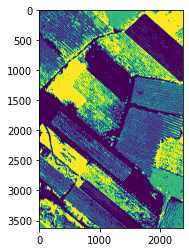

In [ ]:
# show the whole image
# The whole data is too big to test in one time; So dividing it into several parts
from scipy import io

part = 5000
pred_all = np.empty((m*n, 1), dtype='float32')

number = m*n//part
for i in range(number):
    D = np.empty((part, l, patchsize, patchsize), dtype='float32')
    count = 0
    for j in range(i*part, (i+1)*part):
        row = j//n
        col = j - row*n
        row2 = row + pad_width
        col2 = col + pad_width
        patch = x2[(row2 - pad_width):(row2 + pad_width), (col2 - pad_width):(col2 + pad_width), :]
        patch = np.reshape(patch, (patchsize * patchsize, l))
        patch = np.transpose(patch)
        patch = np.reshape(patch, (l, patchsize, patchsize))
        D[count, :, :, :] = patch
        count += 1

    temp = torch.from_numpy(D)
    temp = temp.cuda()
    temp2 = cnn(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[i*part:(i+1)*part, 0] = temp3.cpu()
    del temp, temp2, temp3, D

if (i+1)*part < m*n:
    D = np.empty((m*n-(i+1)*part, l, patchsize, patchsize), dtype='float32')
    count = 0
    for j in range((i+1)*part, m*n):
        row = j // n
        col = j - row * n
        row2 = row + pad_width
        col2 = col + pad_width
        patch = x2[(row2 - pad_width):(row2 + pad_width), (col2 - pad_width):(col2 + pad_width), :]
        patch = np.reshape(patch, (patchsize * patchsize, l))
        patch = np.transpose(patch)
        patch = np.reshape(patch, (l, patchsize, patchsize))
        D[count, :, :, :] = patch
        count += 1

    temp = torch.from_numpy(D)
    temp = temp.cuda()
    temp2 = cnn(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[(i + 1) * part:m*n, 0] = temp3.cpu()
    del temp, temp2, temp3, D


pred_all = np.reshape(pred_all, (m, n)) + 1
OA = OA.numpy()
pred_y = pred_y.cpu()
pred_y = pred_y.numpy()
TestDataLabel = TestLabel.cpu()
TestDataLabel = TestDataLabel.numpy()

io.savemat(savepath, {'PredAll': pred_all, 'OA': OA, 'TestPre': pred_y, 'TestLabel': TestDataLabel})

print(io.loadmat(savepath))
#
plt.figure()
plt.imshow(pred_all)
plt.show()

In [ ]:
OA

array(0.9999119, dtype=float32)

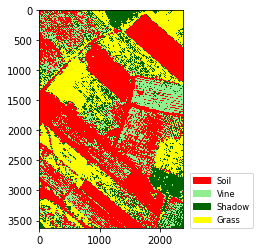

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches

#  matplotlib color specification: https://matplotlib.org/stable/tutorials/colors/colors.html
cmap = ListedColormap(["red", "lightgreen", "darkgreen", "yellow"])
label=["Soil", "Vine", "Shadow",  "Grass"]
#set_trace()

#plt.figure(figsize = (10,8))

patches=[mpatches.Patch(color=cmap.colors[i], label=label[i]) for i in range(len(label))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., fontsize='small')
plt.imshow(pred_all, cmap=cmap)
#plt.show()
plt.savefig('/content/drive/MyDrive/dataset/Gaillac-UAV-ML-2016-subset2/classification_map.jpeg', dpi=400)


In [ ]:
pred_all.shape[0]

3622

In [ ]:


md = {'description ' : '{Convelutional Neural Network Result}',
      'map info ' : '{Lambert Conformal Conic, 1.0000, 1.0000, 612671.3900, 6323154.0000, 1.0000000149e-001, 1.0000000149e-001, Reseau Geodesique Francaise, units=Meters}',
      'projection info ' : '{4, 6378137.0, 6356752.3, 46.500000, 3.000000, 700000.0, 6600000.0, 44.000000, 49.000000, Reseau Geodesique Francaise, Lambert Conformal Conic, units=Meters}',
      'Coordinate system string ': '{PROJCS["Lambert Conformal Conic",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",44.0],PARAMETER["Standard_Parallel_2",49.0],PARAMETER["Scale_Factor",1.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]}',
      'wavelength units ' : 'Unknown' ,
      'lines': pred_all.shape[0], 'samples': pred_all.shape[1],'bands': 1}
#img = envi.create_image('savemappath', md)
#envi.save_classification()
envi.save_classification('/content/drive/MyDrive/dataset/Gaillac-UAV-ML-2016-subset2/pred_all.hdr', pred_all, dtype=np.float32, metadata=md, force=True)
# savemappath='/content/drive/MyDrive/Gaillac-UAV-ML-2016/ClassifiedMap.hdr'